# Advanced Lane Lines

### Udacity Self-driving cars Nano degree
### Term 1 project 'Advanced Lanes Lines'

### Claus H. Rasmussen, dec 2017.
- - - - -

### Import Python modules

In [1]:
import glob
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


### Test of Camera calibration methods

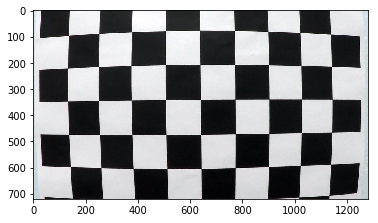

In [2]:
# prepare object points
nx = 9
ny = 6

# Make a list of calibration images
fname = './camera_cal/calibration1.jpg'
img = cv2.imread(fname)
plt.imshow(img)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


### Function *find_obj_and_img_points()*
#### Read a list of calibration images and return arrays with object points and image points to be used in the camera calibration.

In [3]:
# Calibrating your camera (#10)
def find_obj_and_img_points():
    # Read in and make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')


    # Read in a single calibration image
    #img = mpimg.imread('./camera_cal/calibration1.jpg')
    #plt.imshow(img)

    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (7,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates, shaped back into two columns


    print('Number of calibration images: ' + str(len(images)))
    # Iterate through the files
    for fname in images:
        # Read in each image
        filename = fname.split('/')[-1]
        img = mpimg.imread(fname)

        # Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If corners are found, add object points, image points
        if ret == True:
            print('Filename: ' + fname)
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imsave('./output_images/cal_images/' + filename, img)

    return imgpoints, objpoints

### Calculate the reprojection error

In [4]:
def reprojection_error(imgpoints, objpoints, rvecs, tvecs, mtx, dist):
#(https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html)
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error

    print("Total reprojection error: ", mean_error/len(objpoints)) 
    return mean_error/len(objpoints)

### Function *calibrate_camera()*
#### Used in this project

In [5]:
def calibrate_camera(imgpoints, objpoints, img):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

### Functions to undistort an image

In [6]:
#Undistort an image by filename
def undistort(fname, mtx, dist):
    img = mpimg.imread(fname)
    return cv2.undistort(img, mtx, dist, None, mtx)#Undistort an image by filename

def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Test of camera calibration

In [7]:
#Pipeline 1 - calibrate camera
img = './test_images/straight_lines1.jpg'
imgpoints, objpoints = find_obj_and_img_points()
ret, mtx, dist, rvecs, tvecs = calibrate_camera(imgpoints, objpoints, img)
mean_err = reprojection_error(imgpoints, objpoints, rvecs, tvecs, mtx, dist)

Number of calibration images: 20
Filename: ./camera_cal/calibration10.jpg
Filename: ./camera_cal/calibration11.jpg
Filename: ./camera_cal/calibration12.jpg
Filename: ./camera_cal/calibration13.jpg
Filename: ./camera_cal/calibration14.jpg
Filename: ./camera_cal/calibration15.jpg
Filename: ./camera_cal/calibration16.jpg
Filename: ./camera_cal/calibration17.jpg
Filename: ./camera_cal/calibration18.jpg
Filename: ./camera_cal/calibration19.jpg
Filename: ./camera_cal/calibration2.jpg
Filename: ./camera_cal/calibration20.jpg
Filename: ./camera_cal/calibration3.jpg
Filename: ./camera_cal/calibration6.jpg
Filename: ./camera_cal/calibration7.jpg
Filename: ./camera_cal/calibration8.jpg
Filename: ./camera_cal/calibration9.jpg
Total reprojection error:  0.1539354946677939


### Test of undistorting an image

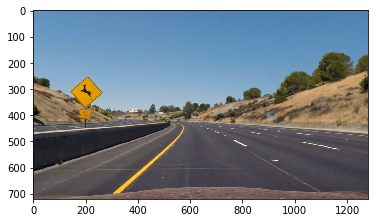

In [8]:
#Pipeline 2 - undistort images
fname = './test_images/test2.jpg' #straight_lines2.jpg'
dst = undistort(fname, mtx, dist)
plt.imshow(dst)
plt.imsave('./output_images/cal_images/test2_undistorted.jpg', dst)


### Three tresholding functions and a function, that combines them, *combined_tresh()*
#### These functions are not used in the pipeline in this project

In [9]:
# Thresholding functions

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale - has been done
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sbl = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sbl = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sbl = np.absolute(sbl)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sbl = np.uint8(255*abs_sbl/np.max(abs_sbl))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sbl)
    grad_binary[(scaled_sbl >= thresh[0]) & (scaled_sbl <= thresh[1])] = 1
    #plt.imshow(grad_binary, cmap='gray')
    # 6) Return this mask as your binary_output image
    return grad_binary

# - - -

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale - has been done
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

# - - -

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
   # 1) Convert to grayscale - has been done
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    # Calculate the x and y gradients
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# - - -

def combined_thresh(image, ksize=3):
    # Apply each of the thresholding functions
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize*5, thresh=(0.7, 1.3)) #(0, np.pi/2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined


### Test *combined_tresh()* function

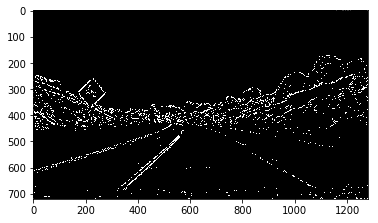

In [10]:
# test
ksize = 3
img = mpimg.imread('./test_images/test2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#comb_img = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
#comb_img = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
#comb_img = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
#comb_img = dir_threshold(gray, sobel_kernel=ksize*5, thresh=(0.7, 1.3))
comb_img = combined_thresh(img)
plt.imsave('./output_images/test2_combined_thresh.jpg', comb_img)
plt.imshow(comb_img, cmap='gray')


### Function *combine_s_color_and_gradient()*
#### Returns a combined binary of S-channel from HLS and gradient treshold using Sobel in x.
#### Used in this project, called from function *cal_tresh_warp()*

In [11]:
# Combine color (s-channel) and gradient thresholds
def combine_s_color_and_gradient(img, plot= False):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    if plot == True:
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary)

        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')

    return combined_binary

### Test function *combine_s_color_and_gradient()*

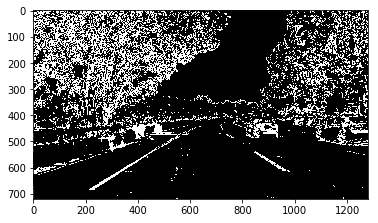

In [12]:
img = mpimg.imread('./test_images/test5.jpg')
combined_binary = combine_s_color_and_gradient(img)
plt.imsave('./output_images/test5_combine_s_color_and_gradient.jpg', combined_binary, cmap='gray')
plt.imshow(combined_binary, cmap='gray')

### Function *yw_combine_thresh()* and helper functions
#### Suggested functions to use (received during the first review)

In [13]:
def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask

def yw_combine_thresh(image):
    yellow = select_yellow(image)
    white = select_white(image)
    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1
    return combined_binary



### Test function *yw_combine_thresh()*

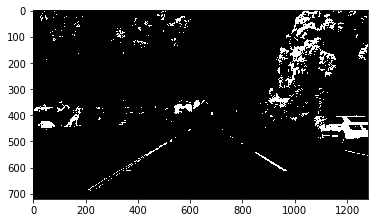

In [14]:
img = mpimg.imread('./test_images/test5.jpg')
combined_binary = yw_combine_thresh(img)
plt.imsave('./output_images/test5_yw_combine_thresh.jpg', combined_binary, cmap='gray')
plt.imshow(combined_binary, cmap='gray')

### Test warping a single image
#### Used to find the best possible manually eyeballed source and desired coordinates.

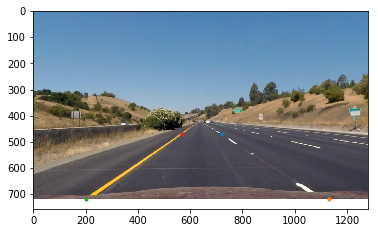

In [15]:
# Warping images

# Read in a single image
fname = './test_images/straight_lines1.jpg'
img = mpimg.imread(fname)
dst = undistort(fname, mtx, dist)
# ---
%matplotlib inline
###%matplotlib qt

# Source image points

plt.imshow(dst)
plt.plot(720, 470, '.') #top right corner
plt.plot(1130, 720, '.') #bottom right corner
plt.plot(200, 720, '.') #bottom left corner
plt.plot(570, 470, '.') #top left corner
plt.imsave('./output_images/straight_lines1_undistorted.jpg', dst)


### Function *warp()*
#### Used in this project to warp images. Both source and desired coordinates are manually handpicked.

In [16]:
# Warp function - perspektive transform function
def warp(img):

    # Define calibration box in source (original) and destination (desired or warped) coordinates

    img_size = (img.shape[1], img.shape[0])

    # Four source coordinates
    src = np.float32(
        [[720, 470],
         [1130, 720],
         [200, 720],
         [570, 470]])

    # Four desired coordinates (just eye-balled in the video)
    dst = np.float32(
        [[980, 0],
         [980, 720],
         [320, 720],
         [320, 0]])

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform, Minv
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv


### Test function *warp()* on a single image

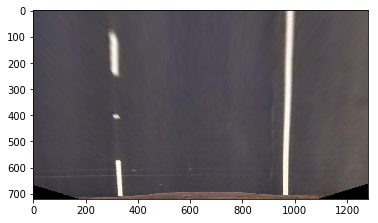

In [17]:
%matplotlib inline
fname = './test_images/straight_lines2.jpg'
#fname = './test_images/test6.jpg'

img = mpimg.imread(fname)
dst = undistort(fname, mtx, dist)
warped, M, Minv = warp(dst)
plt.imsave('./output_images/straight_lines2_warped.jpg', warped)
#plt.imsave('./output_images/test6_warped.jpg', warped)
plt.imshow(warped)


### Function *cal_tresh_warp()*
#### Used in this project to calibrate, treshold and warp an image

In [18]:
def cal_tresh_warp(img):
   # calibrate
    dst = undistort_img(img, mtx, dist)
    # treshold
    #combined_binary = combine_s_color_and_gradient(dst)
    # threshold with yellow&white algorithm only
    combined_binary = yw_combine_thresh(img)
    # perspective transform
    warped, M, Minv = warp(combined_binary)
    return warped, M, Minv

### Test the use of a histogram to find the x values for the two lanes

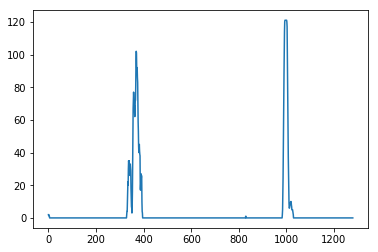

In [19]:
# Plot histogram of lower calibrated, thresholded, and perspective transformed road image

fname = './test_images/test3.jpg'
img = mpimg.imread(fname)

warped, M, Minv = cal_tresh_warp(img)
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.imsave('./output_images/test3_histogram.jpg', warped)
plt.plot(histogram)


### Class Line
#### Used to hold param for each left and right line, instead on using global vars.
#### Contains only one function, *add_new_fit()* to add a new fit for a line and calculate the *self.best_fit* used to draw lines.

In [20]:
# Class Line - one for each line

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # previous polyline
        self.prev_best_fit = None
        # previous fit x values
        self.prev_fitx = []
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #number of fits used in average
        self.nfits = 5
        #counts for lane reuse
        self.n = 0
        
    def add_new_fit(self, new_fit, new_indices):
        # func inspired by Jeremy Shannon, former sdcnd student. Found on GitHub - errors corrected :-).
        # add a found fit to the line, up to n
        #print("new_fit")
        #print(new_fit)
        if new_fit is not None:
            if self.prev_best_fit is None:
                self.prev_best_fit = new_fit
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(new_fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # this is a bad fit, but will be used if the current_fit queue is empty
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(new_indices)
                self.current_fit.append(new_fit)
                #print("len(self.current_fit)")
                #print(len(self.current_fit))
                #print(self.current_fit)
                if len(self.current_fit) > self.nfits:
                    # throw out old fits, keep newest self.nfits entries
                    self.current_fit = self.current_fit[len(self.current_fit) - self.nfits:]
                self.best_fit = np.average(self.current_fit, axis=0)
                #print("self.best_fit")
                #print(self.best_fit)
        # the new fit has not been found, so remove one from the history
        else:
            self.detected = False
            #if len(self.current_fit) > 0:
                # throw out oldest fit
                #self.current_fit = self.current_fit[:len(self.current_fit) - 1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
                self.prev_best_fit = self.best_fit

        #print("self.best_fit 2")
        #print(self.best_fit)
        if self.best_fit is None:
            self.best_fit = self.prev_best_fit
        #print("self.best_fit 3")
        #print(self.best_fit)


### Functions *curvature()*, *slide_windows()*, and *skip_sliding()*
#### These functions are used in this project to find the lines in the images/videos

In [21]:
# Find the curvature of two lines
def curvature(lefty, leftx, righty, rightx, ploty):
    # Define conversions in x and y from pixels space to meters, measured in tes3.jpg
    ym_per_pix = 3/140 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad
    
# Find the Lanes by using a sliding window.
def slide_windows(binary_warped, nwin=9, plot=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = nwin
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    l_lane.allx = leftx
    l_lane.ally = lefty
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    r_lane.allx = rightx
    r_lane.ally = righty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # calculate curvature
    left_curverad, right_curverad = curvature(lefty, leftx, righty, rightx, ploty)
    
    if plot:

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, left_curverad, right_curverad

# Find the Lanes by using the results from previous frame
def skip_sliding(binary_warped, left_fit, right_fit, plot=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    l_lane.allx = leftx
    l_lane.ally = lefty
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    r_lane.allx = rightx
    r_lane.ally = righty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # calculate curvature
    left_curverad, right_curverad = curvature(lefty, leftx, righty, rightx, ploty)


    if plot:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return left_fit, right_fit, left_curverad, right_curverad

### Test function *slide_windows()* on a single image

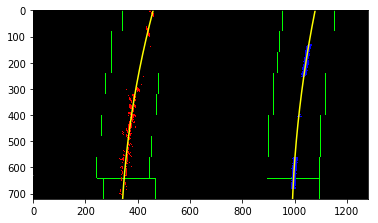

In [22]:
# Test of def slide_windows()

l_lane = Line()
r_lane = Line()

fname = './test_images/test3.jpg'
img = mpimg.imread(fname)

warped, M, Minv = cal_tresh_warp(img)
left_fit, right_fit, left_curverad, right_curverad = slide_windows(warped, nwin=9, plot=True)

### Test function *skip_sliding()* on a single image

(array([  1.39105228e-04,  -2.61823761e-01,   4.58903595e+02]),
 array([  1.11013436e-04,  -1.99522820e-01,   1.07826633e+03]),
 290.06819512847045,
 363.38387862677729)

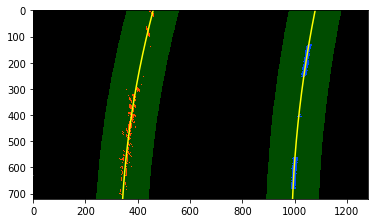

In [23]:
# test of def skip_slide()

skip_sliding(warped, left_fit, right_fit, plot=True)

### Functions to find centroids for small sliding windows on a warped image of lines
#### Contains functions *window_mask()* and *find_window_centroids()*. The former returns an array of centroids to use in creating polylines.
#### This approach has not been used in this project.

In [24]:
# Sliding Windows search
# Read in a thresholded image

# window settings
# window_width
# window_height : Break image into 9 vertical layers since image height is 720
#margin : How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width=50, window_height=80, margin=100, plot=False):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))
        
    if plot == True:
        # If we found any window centers
        if len(window_centroids) > 0:

            # Points used to draw all the left and right windows
            l_points = np.zeros_like(warped)
            r_points = np.zeros_like(warped)

            # Go through each level and draw the windows 	
            for level in range(0,len(window_centroids)):
                # Window_mask is a function to draw window areas
                l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
                r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
                # Add graphic points from window mask here to total pixels found 
                l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
                r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

            # Draw the results
            template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
            zero_channel = np.zeros_like(template) # create a zero color channel
            template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
            warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
            output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
        else:
            output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

        # Display the final results
        plt.imshow(output)
        plt.title('Window fitting results')
        plt.show()

    return window_centroids




### Test function *find_window_centroids()* on a single image

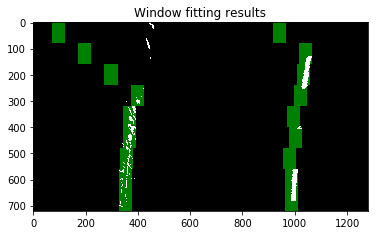

[(353.0, 987.0), (353.0, 987.0), (356.0, 981.0), (367.0, 1004.0), (370.0, 997.0), (398.0, 1023.0), (298.0, 1033.0), (198.0, 1041.0), (98.0, 941.0)]


In [25]:
# Test of def find_windows_centroids()

window_centroids = find_window_centroids(warped, plot=True)
print(window_centroids)


### Calculate and evalute the mean distance between two polylines
#### Input is two polylines for the same lane (left or right) from two consecutive frames

### Function *mean_dist()* and *eval_mean_dist()*

In [26]:
# Calculate the mean distance between two polylines
def mean_dist(prev_poly, curr_poly):
    mean_distance = 0
    for i in range(len(prev_poly)):
        mean_distance += (prev_poly[i][0] - curr_poly[i][0])**2 + (prev_poly[i][1] - curr_poly[i][1])**2
    mean_distance /= len(prev_poly)
    mean_distance = math.sqrt(mean_distance)
    return mean_distance


# Evaluate the mean distance between two polylines
def eval_mean_dist(curr_left_poly, curr_right_poly, left_fitx, right_fitx):
    # 
    mean_left_dist = 0
    mean_right_dist = 0
    if l_lane.prev_poly != []:
        prev_left_poly = l_lane.prev_poly
        mean_left_dist = mean_dist(prev_left_poly, curr_left_poly)
        prev_right_poly = r_lane.prev_poly
        mean_right_dist = mean_dist(prev_right_poly, curr_right_poly)
        if abs(mean_left_dist) < 10 or l_lane.n > 3:
            l_lane.prev_poly = curr_left_poly
            l_lane.prev_fitx = left_fitx
            l_lane.n = 0
        else:
            left_fitx = l_lane.prev_fitx
            l_lane.n += 1
        if abs(mean_right_dist) < 10 or r_lane.n > 3:
            r_lane.prev_poly = curr_right_poly
            r_lane.prev_fitx = right_fitx
            r_lane.n = 0
        else:
            right_fitx = r_lane.prev_fitx
            r_lane.n += 1
    else:
        l_lane.prev_poly = curr_left_poly
        r_lane.prev_poly = curr_right_poly
        l_lane.prev_fitx = left_fitx
        r_lane.prev_fitx = right_fitx
        
    return left_fitx, right_fitx, mean_left_dist, mean_right_dist


### Function *draw_on_image()*

In [27]:
# Draw on a warped image, rewarp it and add it to the original undisturbed image

def draw_on_image(undist, warped, Minv, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

### Function *process_one_image()*

In [28]:
def process_one_image(image):
    image_copy = np.copy(image)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    binary_warped, M, Minv = cal_tresh_warp(dst)
    
    # if both left and right lines were detected last frame, use skip_sliding(...), otherwise use slide_windows(...)
    if not l_lane.detected or not r_lane.detected:
        #print("not l_lane.detected or not r_lane.detected")
        left_fit, right_fit, left_curverad, right_curverad = slide_windows(binary_warped, nwin=9)
    else:
        left_fit, right_fit, left_curverad, right_curverad = skip_sliding(binary_warped, l_lane.best_fit, r_lane.best_fit)
        #print("skip_sliding - left_fit")
        #print(left_fit)
        #print("skip_sliding - right_fit")
        #print(right_fit)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    curr_left_poly = np.array(list(zip(left_fitx, ploty)))
    curr_right_poly = np.array(list(zip(right_fitx, ploty)))
    
    camera_position = image.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(camera_position - lane_center)
    xm_per_pix = 3.7/650 # meters per pixel in x dimension
    center_offset_m = center_offset_pixels * xm_per_pix
    curvature = (left_curverad + right_curverad) / 2.0
    
    #check the distance between the two found lanes at the bottom of the warped image
    #invalidate if the difference is more than 660 pixels +- 100
    h = img.shape[0]
    l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    x_int_diff = abs(r_fit_x_int-l_fit_x_int)
    #print(l_fit_x_int)
    #print(r_fit_x_int)
    #print(x_int_dif)
    if abs(660 - x_int_diff) > 100:
        left_fit = None
        right_fit = None
            
    l_lane.add_new_fit(left_fit, left_fitx)
    r_lane.add_new_fit(right_fit, right_fitx)

    # Use the mean dist between curent and previous polylines to handles the lanes
    # I never got it to function correctly in the last curve
    use_mean_dist = False
    mean_left_dist = 0
    mean_right_dist = 0
    if use_mean_dist:
        left_fitx, right_fitx, mean_left_dist, mean_right_dist = eval_mean_dist(curr_left_poly, curr_right_poly, left_fitx, right_fitx)

    # draw the current best fit if it exists
    use_best_fit = True
    if use_best_fit:
        if l_lane.best_fit is not None and r_lane.best_fit is not None:
            # get the best fit for both lanes
            #print("l_lane.best_fit")
            #print(l_lane.best_fit)
            #print("r_lane.best_fit")
            #print(r_lane.best_fit)
            left_fit = l_lane.best_fit
            right_fit = r_lane.best_fit
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            # corrected code from remarks during the first review in order to use the undistorted image as output.
            #result = draw_on_image(image, binary_warped, Minv, ploty, left_fitx, right_fitx)
            result = draw_on_image(dst, binary_warped, Minv, ploty, left_fitx, right_fitx)
        else:
            result = dst

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Curvature: ' + str("{:10.1f}".format(curvature)) + 'm',(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Distance from center line: ' + str("{:10.3f}".format(center_offset_m)) + 'm',(10,150), font, 1,(0,255,255),2,cv2.LINE_AA)

    print_diagnostics = False
    if print_diagnostics:
        cv2.putText(result,'mean_left_dist: ' + str("{:10.2f}".format(mean_left_dist)) + 'm',(800,100), font, 1,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(result,'mean_right_dist: ' + str("{:10.2f}".format(mean_right_dist)) + 'm',(800,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result


### Run test on a single image
#### Using function *process_one_image()*

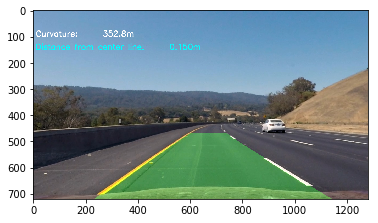

In [29]:
# test a single image
l_lane = Line()
r_lane = Line()

fname = './test_images/test3.jpg'
img = mpimg.imread(fname)
result = process_one_image(img)
plt.imsave('./output_images/test3_w_lane.png', result)
plt.imshow(result)

### Function *write_video()* to create a new annotated video
#### Used in the calls below

In [30]:
def write_video(in_fname, out_fname):
    output_video = out_fname
    #clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(4,9)
    input_clip = VideoFileClip(in_fname)#.subclip(1,10)
    output_clip = input_clip.fl_image(process_one_image) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(output_video, audio=False)



### Run pipeline on *project_video.mp4*

In [31]:
# run a whole movie
l_lane = Line()
r_lane = Line()

write_video('project_video.mp4', './output_images/project_video_w_lanes_yw.mp4')

[MoviePy] >>>> Building video ./output_images/project_video_w_lanes_yw.mp4
[MoviePy] Writing video ./output_images/project_video_w_lanes_yw.mp4


100%|█████████▉| 1260/1261 [03:54<00:00,  5.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_w_lanes_yw.mp4 

CPU times: user 19min 48s, sys: 5min 49s, total: 25min 38s
Wall time: 3min 55s


### Run pipeline on *Challenge_video.mp4*

In [32]:
# run a whole movie
l_lane = Line()
r_lane = Line()

#write_video('challenge_video.mp4', './output_images/challenge_video_w_lanes.mp4')

### Run pipeline on *Harder_challenge_video.mp4*

In [33]:
# run a whole movie
l_lane = Line()
r_lane = Line()

#write_video('harder_challenge_video.mp4', './output_images/harder_challenge_video_w_lanes.mp4')